In [13]:
# importing the required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def show_image(image, title, cmap=None):
    # function to display images using matplotlib.
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [15]:
def preprocess_image(image_path):
    # Loading the image, converting to grayscale, and applying Gaussian blur.
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting for correct visualization
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Converting to grayscale
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Applying Gaussian Blur to reduce noise

    # displaying the results achieved
    show_image(image_rgb, "Original Image")
    show_image(gray, "Grayscale Image", cmap="gray")
    show_image(blurred, "Blurred Image", cmap="gray")

    return image, gray, blurred

In [16]:
def apply_threshold(blurred):
    # Applying adaptive thresholding to highlight coins.
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    show_image(thresh, "Thresholded Image", cmap="gray")
    return thresh

In [17]:
def find_coin_contours(thresh):
    # Finding contours in the thresholded image.
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [18]:
def filter_and_draw_coins(image, contours):
    # Filtering valid coins based on area & circularity
    # Drawing circles around them and returning the valid contours.
    coin_count = 0
    detected_contours = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue

        circularity = 4 * np.pi * (area / (perimeter * perimeter))

        # Filtering based on area and circularity
        if 3000 < area < 50000 and 0.5 < circularity < 1.3:
            coin_count += 1
            detected_contours.append(cnt)
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(image, center, radius, (0, 255, 0), 3)  # Drawing detected coins

    return image, coin_count, detected_contours

In [19]:
def segment_coins(image, contours):
    # Segmenting each detected coin using contour-based region segmentation.
    segmented_coins = []

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        coin = image[y:y+h, x:x+w]  # Cropping the detected region

        # Creating a mask to remove the background
        mask = np.zeros(coin.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [cnt - [x, y]], -1, (255), thickness=cv2.FILLED)
        coin_segmented = cv2.bitwise_and(coin, coin, mask=mask)

        segmented_coins.append(coin_segmented)

        # Displaying each segmented coin
        show_image(cv2.cvtColor(coin_segmented, cv2.COLOR_BGR2RGB), f"Segmented Coin {i+1}")

    return segmented_coins

In [20]:
def detect_and_segment_coins(image_path):
    # This is the main function that detects coins, outlines them, and segments them.

    # Step 1: Preprocessing
    image, gray, blurred = preprocess_image(image_path)

    # Step 2: Thresholding
    thresh = apply_threshold(blurred)

    # Step 3: Contour Detection
    contours = find_coin_contours(thresh)

    # Step 4: Filtering and Drawing Coins
    image_with_coins, coin_count, detected_contours = filter_and_draw_coins(image, contours)

    # Converting BGR to RGB before displaying
    image_rgb = cv2.cvtColor(image_with_coins, cv2.COLOR_BGR2RGB)
    show_image(image_rgb, f'Detected Coins: {coin_count}')

    # Step 5: Segmentation
    segmented_coins = segment_coins(image, detected_contours)

    return coin_count, segmented_coins

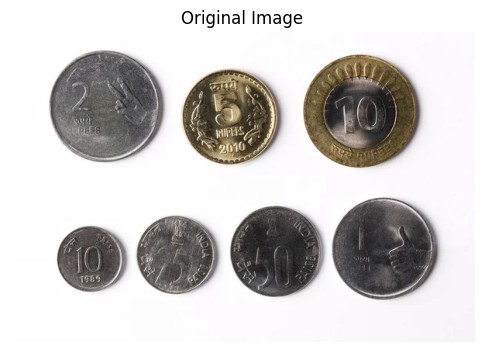

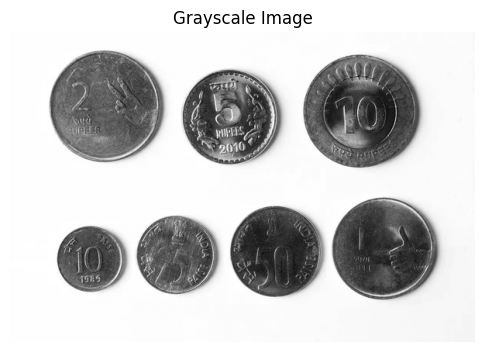

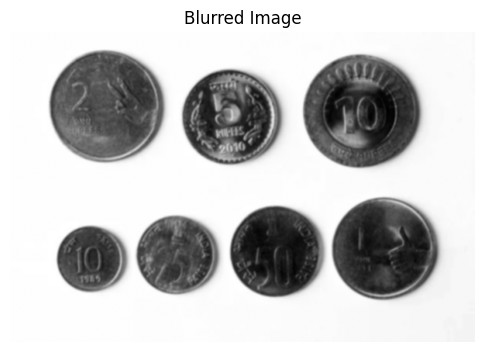

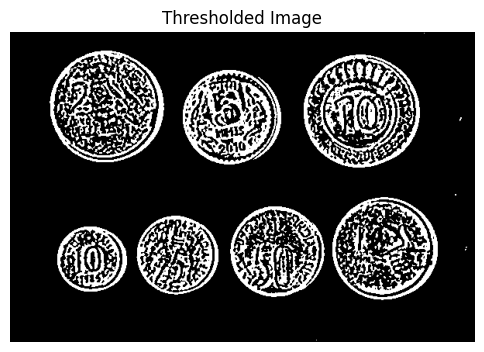

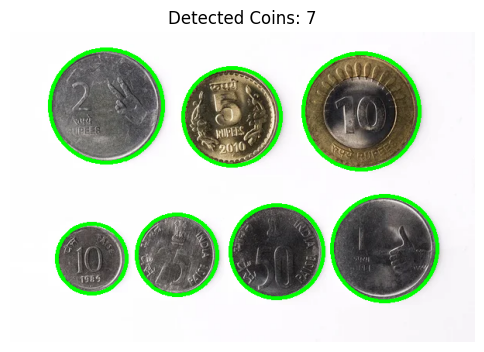

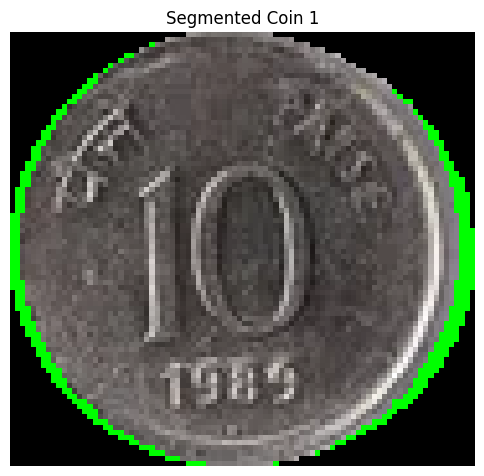

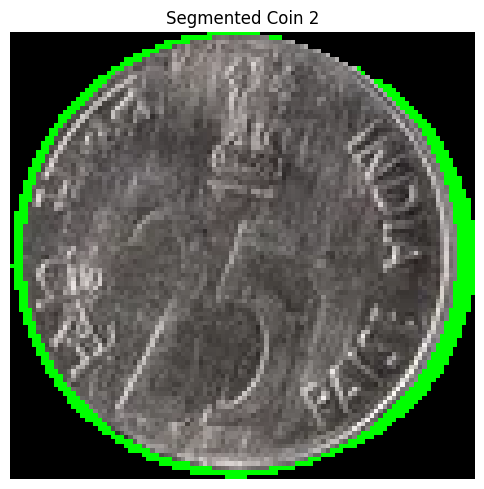

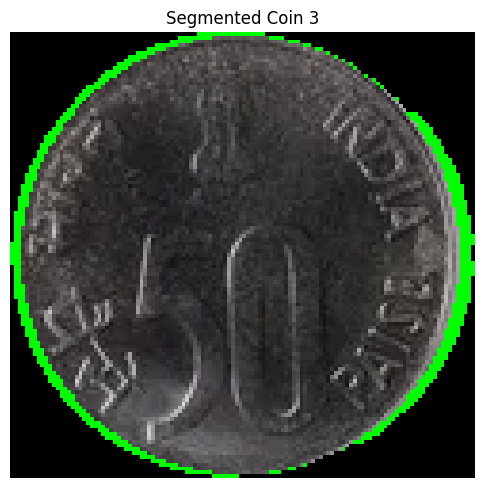

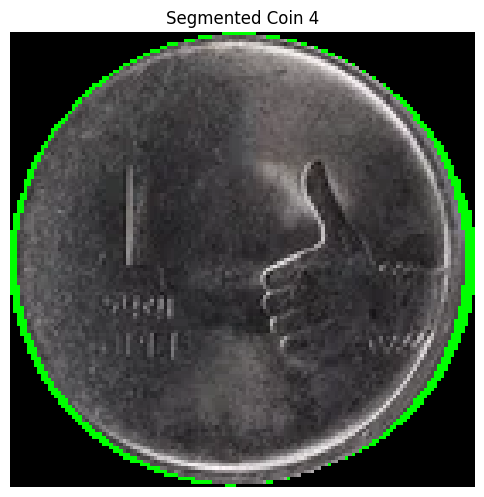

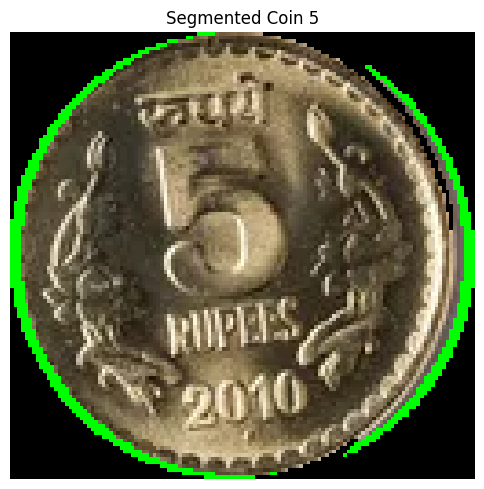

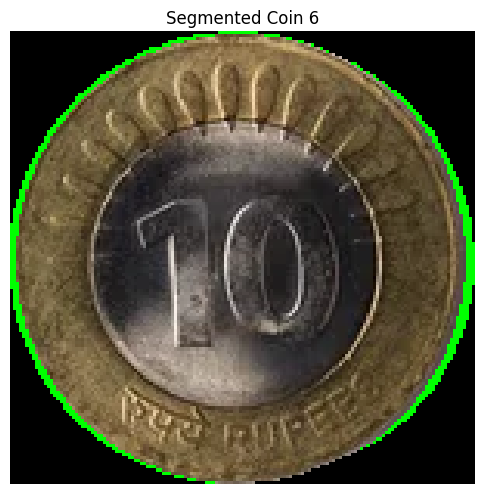

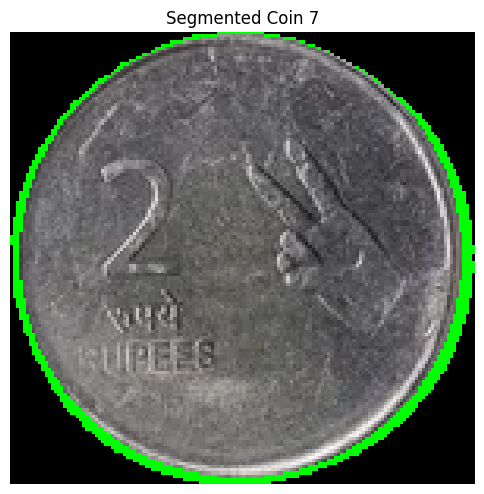

Total Number of Coins: 7


In [21]:
# Run detectioning and segmentation
image_path = "/content/coins.jpg"
total_coins, segmented_coins = detect_and_segment_coins(image_path)

print(f'Total Number of Coins: {total_coins}')
